# Getting familiar with quantile regression

Let's build a neural network which will fit the quantiles of a gaussian distribution

## Creating the neural network to fit the qantiles

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim  as optim
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.fc1 = nn.Linear(2, 10)
        self.fc2 = nn.Linear(10, 10)
        self.fc3 = nn.Linear(10, 9)
    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

## Generate a sample to fit
- $X = (x_1,  x_2)$
- $Y \sim x_1 + 2 x_2 + 1 \epsilon$
with $\epsilon \sim \mathcal{N}(0,1)$

In [4]:
import numpy as np
Nsample = 10**6
X = torch.rand(Nsample,2, dtype=torch.float32)
W = torch.tensor([[1], [2]], dtype=torch.float32)
noise = torch.randn(Nsample,1, dtype=torch.float32)
Y = torch.mm(X, W) + noise

X_test = torch.rand(Nsample,2, dtype=torch.float32)
W_test = torch.tensor([[1], [2]], dtype=torch.float32)
noise_test = torch.randn(Nsample,1, dtype=torch.float32)
Y_test = torch.mm(X, W) + noise

The pinball loss between an estimator $z$ and a target variable $y$ is 

$$ \text{Loss}(z, y) = \sum_i \max (y - z , 0) q_i + \max (z - y , 0) (1 - q_i) $$

where the $\{q_i\}$ are a list of quantiles. 

In [6]:
net = Net()
def PinballLoss(qtiles, epsilon=1):
    def Loss(real_value, nn_output):
        ordering_term = torch.mean(torch.max(nn_output[:,:-1] - nn_output[:,1:], torch.zeros_like(nn_output[:,1:])))
        error = real_value * torch.ones_like(nn_output) - nn_output 
        qp = torch.max(error, torch.zeros_like(error)) * qtiles
        qm = torch.max(- error, torch.zeros_like(error)) * (1 - qtiles)
        return torch.mean(qp + qm) + epsilon * ordering_term
    return Loss
print('real value shape', Y.shape)
print('output shape', net(X).shape)
qtiles = np.arange(0.1,1,0.1)
tensor_qtiles = torch.tensor(qtiles, dtype=torch.float32)
output = torch.tensor(np.array([qtiles, qtiles]),
                      dtype=torch.float32)
real_value = torch.tensor([[1],[2]], dtype=torch.float32)
assert output.shape == (2, 9)
assert real_value.shape == (2, 1)
assert tensor_qtiles.shape == torch.Size([9])
loss = PinballLoss(qtiles=tensor_qtiles)

real value shape torch.Size([1000000, 1])
output shape torch.Size([1000000, 9])


In [12]:
net = Net()
criterion = PinballLoss(tensor_qtiles)
optimizer = optim.Adam(net.parameters(), 
                       lr=0.001, betas=(0.9, 0.999), weight_decay=0.0, amsgrad=False)
for n_epoch in range(500):    
    total_loss = []
    intermediate_loss = []
    optimizer.zero_grad()
    inp = X
    output = net(inp)
    loss = criterion(Y, output)
    loss.backward()
    total_loss.append(float(loss.detach().cpu().numpy()))
    intermediate_loss.append(float(loss.detach().cpu().numpy()))
    optimizer.step()
    if n_epoch% 100 == 0: 
        print('epoch {} \n'.format(n_epoch))
        print(loss)

epoch 0 

tensor(0.9982, grad_fn=<ThAddBackward>)
epoch 100 

tensor(0.6323, grad_fn=<ThAddBackward>)
epoch 200 

tensor(0.3328, grad_fn=<ThAddBackward>)
epoch 300 

tensor(0.3264, grad_fn=<ThAddBackward>)
epoch 400 

tensor(0.3206, grad_fn=<ThAddBackward>)


## Did we get the quantiles we were looking for 

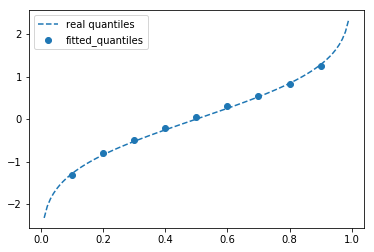

In [27]:
from scipy.stats import norm
import pylab as plt
%matplotlib inline
to_analyse = (net(X) - torch.mm(X, W) ).detach().numpy()
plt.scatter(np.arange(0.1, 1, 0.1), 
            to_analyse.mean(axis=0), 
           label='fitted_quantiles')
xv = np.arange(0.01,1,0.01)
plt.plot(xv, norm.ppf(xv), label='real quantiles', ls='--')
plt.legend(loc='best')